# **Wikipedia Trends Data Exploration Notebook**

---



# [Contents](#0)


1.   [Import required Libraries & Load the dataset using pandas](#1)
2.   [Preprocessing_module](#2)
3.   [Information about the dataset](#3)
4.   [(Q) Does page Language really matters in Wiki Edits and Unique users for each language ? ](#4)
5.   [Which language contributes the most in edits per minute qty along with their **distribution** ? (Top 5)](#5)

6.   [(Q) Edits per minute for **all languages** present in the dataset (Global data) ? ](#6)

7.   [(Q) Edits per minute for **German language** present in the dataset ? ](#7)

8.   [(Q) Unique Users per minutes for **German language** present in the dataset](#8)

9.   [(Q) Rolling Avg. of length of edit in German Wikipedia (length_old- length_new) ? ](#9)


10.   [(Q) Rolling Avg. of comments length in German Wikipedia (comments length) ? ](#10)

11.   [Top 5 German URL's edited multiple times during the given time frame ? ](#11)

12.   [Common Wikipedia title between languages and its quantity
](#12)

13.   [Top 10 title for Top 10 Langauges](#13)







<a name="1"></a>
**1. Import req Libraries & Load the dataset using pandas**

In [1]:
#@title Default title text
from google.colab import drive
drive.mount('/content/drive')

FILE_PATH      = '/content/drive/My Drive/exxetta'
FILE_NAME = '20210121_181328_recentchange_part1.parquet'
FILE_NAME_COUNTRY = 'Book1.xlsx'


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import re
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Standard plotly imports
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import tools
from collections import Counter
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = "colab"

# !pip install hvplot
# !pip install git+https://github.com/ioam/holoviews.git
# !pip install git+https://github.com/bokeh/datashader.git
# pip install streamz



df = pd.read_parquet(FILE_PATH + '/' + FILE_NAME, engine='pyarrow').reset_index(drop= True)
print('Shape:', df.shape)
fixed_cols = df.columns.tolist()


Mounted at /content/drive


Shape: (73565, 29)




---



<a name="2"></a>
**2. Preprocessing Module**

In [2]:
class Preprocessing_mod:
  def __init__(self, df, df_country):
    self.df         = df
    self.df_country = df_country 

  def Datetime_preprocess(self, df):
    df['meta_dt']                    = pd.to_datetime(df['meta_dt'])
    df[['hour', 'minute', 'second']] = pd.DataFrame([(i.hour, i.minute, i.second) for i in df['meta_dt']])
    df['hour_minute']                = df['meta_dt'].apply(lambda x: str(x.hour) + '_' +  '0' + str(x.minute) if len(str(x.minute)) <= 1 else str(x.hour) + '_' + str(x.minute))
    df['utc_converted']              = df['timestamp'].apply(lambda x : datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    print('DataFrame start Date_Time = ', df['meta_dt'].min())
    print('DataFrame End Date_Time = ', df['meta_dt'].max())
    return df

  def Language_preprocess(self, df):
    df['language'] = df['wiki'].apply(lambda x : x.split('wiki')[0])
    df['language'] = df['language'].apply(lambda x : 'wikidata' if len(x) ==0 else x)
    df.loc[df[df.language == 'dewiktionary'].index.values, 'language'] = 'de'
    return df

  def LengthDiff_preprocess(self, df):
    df['length_diff']   = abs(df['length_old'] - df['length_new'])
    df['revision_diff'] = abs(df['revision_old']  - df['revision_new'])
    return df

  def LengthComments_preprocess(self, df):
    df['length_comment'] = df['comment'].apply(lambda x : len(x))
    return df  

  def preprocess_country(self, df , df_country):
    df ['country'] = -1
    for i, df_subset in df.iterrows():
      try:
        df.loc[i, 'country'] = df_country[df_country.Code == df_subset.language]['Country'].values[0].strip()
      except:
        df.loc[i, 'country'] = 'NaN'
    return df 

  def main_func(self):
    df = self.Datetime_preprocess(self.df)
    df = self.Language_preprocess(df)
    df = self.LengthDiff_preprocess(df)
    df = self.LengthComments_preprocess(df)

    return df

df_country = None
call_cls  = Preprocessing_mod(df, df_country)
df        = call_cls.main_func()
df_german = df[df.language == 'de'].reset_index(drop= True)


DataFrame start Date_Time =  2021-01-21 17:11:15+00:00
DataFrame End Date_Time =  2021-01-21 18:13:24+00:00




---



<a name="3"></a>
**3. Basic Information about the dataset**



In [ ]:
#@title Run the cell
print('============================')
print('1. Shape of DF : \n', df.shape)
print('============================')

print()
print('============================')
print('2. Check for null Values :\n', dict(df.isnull().sum()[df.isnull().sum() != 0]))
print('============================')


print()
print('============================')
print(f'3. Dataset_Time Frame starting from : {df.meta_dt.min()} ended at {df.meta_dt.max()}')
print('We almost have 1 hour of Wikipedia Streaming data')
print('============================')


print()
print('============================')
print('4. Information about the dataset : \n', )
print(df.info())
print('============================')


1. Shape of DF : 
 (73565, 38)

2. Check for null Values :
 {'patrolled': 22068}

3. Dataset_Time Frame starting from : 2021-01-21 17:11:15+00:00 ended at 2021-01-21 18:13:24+00:00
We almost have 1 hour of Wikipedia Streaming data

4. Information about the dataset : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73565 entries, 0 to 73564
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   $schema             73565 non-null  object             
 1   id                  73565 non-null  int64              
 2   type                73565 non-null  object             
 3   namespace           73565 non-null  int64              
 4   title               73565 non-null  object             
 5   comment             73565 non-null  object             
 6   timestamp           73565 non-null  int64              
 7   user                73565 non-null  object             
 8   bot    

,$schema,id,type,namespace,title,comment,timestamp,user,bot,minor,patrolled,server_url,server_name,server_script_path,wiki,parsedcomment,meta_domain,meta_uri,meta_request_id,meta_stream,meta_topic,meta_dt,meta_partition,meta_offset,meta_id,length_old,length_new,revision_old,revision_new,hour,minute,second,hour_minute,utc_converted,language,length_diff,revision_diff,length_comment
0,/mediawiki/recentchange/1.0.0,1389063095,edit,0,Q104971167,/* wbeditentity-update-languages-short:0||nl *...,1611249080,Edoderoobot,True,False,True,https://www.wikidata.org,www.wikidata.org,/w,wikidatawiki,"‎<span dir=""auto""><span class=""autocomment"">Ch...",www.wikidata.org,https://www.wikidata.org/wiki/Q104971167,YAm1uApAIIEAACcb76EAAAAA,mediawiki.recentchange,eqiad.mediawiki.recentchange,2021-01-21 17:11:20+00:00,0,2887301727,a62392d6-25d3-405c-9d6c-54956eb60a52,3781,3860,1345581201,1345601868,17,11,20,17_11,2021-01-21 17:11:20,wikidata,79,20667,141
1,/mediawiki/recentchange/1.0.0,116494285,edit,0,Acanthastrea erythraea,[[Wikipedia:Geen samenvatting|Verwijst door]] ...,1611249078,Kvdrgeus,False,False,False,https://nl.wikipedia.org,nl.wikipedia.org,/w,nlwiki,"<a href=""/wiki/Wikipedia:Geen_samenvatting"" ti...",nl.wikipedia.org,https://nl.wikipedia.org/wiki/Acanthastrea_ery...,YAm1tgpAIHwABCtglGIAAADR,mediawiki.recentchange,eqiad.mediawiki.recentchange,2021-01-21 17:11:18+00:00,0,2887301728,f6acf301-d987-4d7b-85fe-d2c3cb486ffb,866,65,48016794,58091518,17,11,18,17_11,2021-01-21 17:11:18,nl,801,10074724,76
2,/mediawiki/recentchange/1.0.0,119689610,edit,0,神楽シリーズ,/* シリーズ作品 */,1611249080,Zaco9876,False,True,None,https://ja.wikipedia.org,ja.wikipedia.org,/w,jawiki,"<span dir=""auto""><span class=""autocomment""><a ...",ja.wikipedia.org,https://ja.wikipedia.org/wiki/%E7%A5%9E%E6%A5%...,YAm1uApAMNwAALESd1YAAAEO,mediawiki.recentchange,eqiad.mediawiki.recentchange,2021-01-21 17:11:20+00:00,0,2887301732,6f36af6f-f84b-421c-bd5d-ebc2eef54f0f,22851,22855,81442784,81442790,17,11,20,17_11,2021-01-21 17:11:20,ja,4,6,12




---



<a name="4"></a>
**4. Does page Language really matters in Wiki Edits and Unique users for each language ?**

In [ ]:
#@title Run the Cell
lang_count = dict(Counter(df.language))
top_n = int(input('Input top N contributing languages: \n'))
print()
print('Top 10 contributing languages with unique users : \n') 
lang_count_tuple = sorted(lang_count.items(), key=lambda x : x[1], reverse=True)[:top_n]
lang_count_tuple = [lang_count_tuple[idx] + (df[df.language == tup[0]]['user'].nunique(),) for idx, tup in enumerate(lang_count_tuple)]
pd.DataFrame(lang_count_tuple, columns= ['Language', 'Edits', 'Unique_users'])


Input top N contributing languages: 
10

Top 10 contributing languages with unique users : 



,Language,Edits,Unique_users
0,wikidata,31299,651
1,commons,11726,449
2,en,9550,2623
3,fr,2100,590
4,de,1767,617
5,it,1281,390
6,es,1265,450
7,ru,1232,377
8,ur,1183,5
9,arz,785,4


<a name="5"></a>
**5. Which language contributes the most in edits per minute qty along with their distribution ? (Top 5) ?** 
1. English tops the list where edits per minute between 100 - 200
2. The remaining languages (French, German, Italy, Spanish) edits per minute less than 50

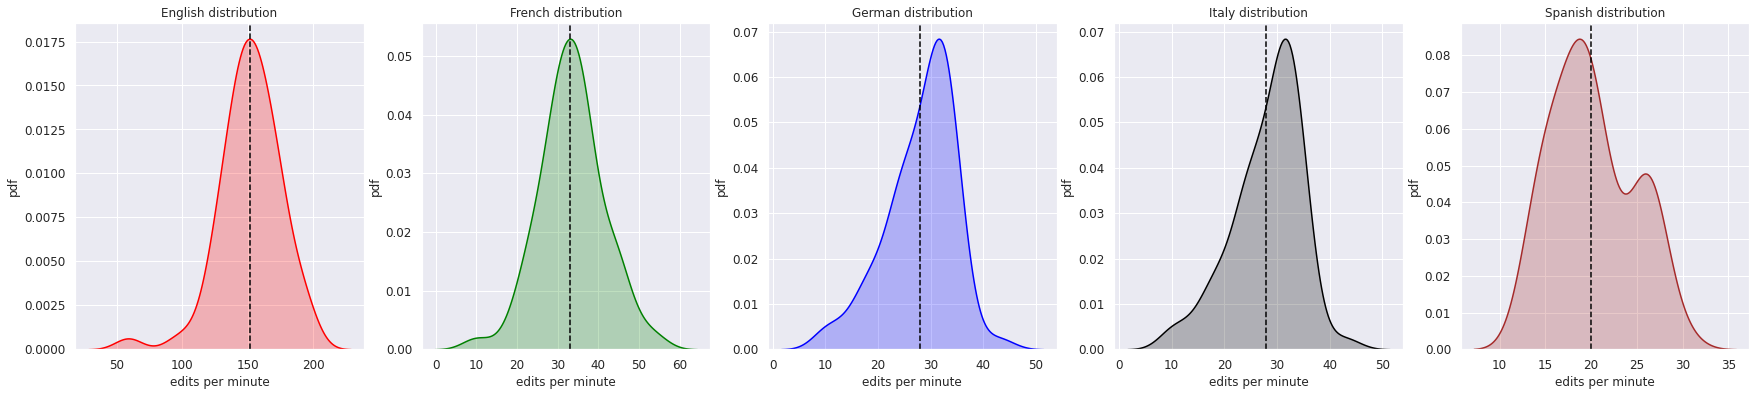

In [ ]:
#@title Run the cell
# 
lang_sets = {}
lang_sets_en = df[df.language =='en']['hour_minute'].value_counts().sort_index()
lang_sets_fr = df[df.language =='fr']['hour_minute'].value_counts().sort_index()
lang_sets_de = df[df.language =='de']['hour_minute'].value_counts().sort_index()
lang_sets_it = df[df.language =='it']['hour_minute'].value_counts().sort_index()
lang_sets_es = df[df.language =='es']['hour_minute'].value_counts().sort_index()


fig = go.Figure()
fig.add_trace(go.Scatter(x=lang_sets_en.index, y=lang_sets_en.values,   mode='lines+markers+text', line= dict(width = 2, dash = 'dot'), marker=dict(color= 'red', size= 7), name = 'English', showlegend=True ))
fig.add_trace(go.Scatter(x=lang_sets_fr.index, y=lang_sets_fr.values,    mode='lines+markers+text', line= dict(width = 2, dash = 'dot'), marker=dict(color= 'green', size= 7), name = 'French',showlegend=True ))
fig.add_trace(go.Scatter(x=lang_sets_de.index, y=lang_sets_de.values,    mode='lines+markers+text', line= dict(width = 2, dash = 'dot'), marker=dict(color= 'blue', size= 7), name = 'German',showlegend=True ))
fig.add_trace(go.Scatter(x=lang_sets_it.index, y=lang_sets_it.values,    mode='lines+markers+text', line= dict(width = 2, dash = 'dot'), marker=dict(color= 'black', size= 7), name = 'Italy',showlegend=True ))
fig.add_trace(go.Scatter(x=lang_sets_es.index, y=lang_sets_es.values,    mode='lines+markers+text', line= dict(width = 2, dash = 'dot'), marker=dict(color= 'brown', size= 7), name = 'Spanish',showlegend=True ))

fig.update_xaxes(tickangle = 270, title_font = {"size": 10},     title_standoff = 25)
fig.update_yaxes(title_font = {"size": 10},     title_standoff = 25)
fig.update_layout(title='Every minute Top 5 Languges wikipedia page updation (between 17:11 till 18:13) ', xaxis_title='Hour_Minute', yaxis_title='No of Edits', height=600, width=1700)
fig.show()

print()
print()

sns.set_theme()
plt.figure(figsize = (30,6))
tit = {1 : 'English', 2 : 'French', 3 : 'German', 4 :'Italy', 5 : 'Spanish'}
color = {1 : 'red', 2 : 'green', 3 : 'blue', 4 :'black', 5 : 'brown'}

for i, arr in zip(range(1, 6), [lang_sets_en, lang_sets_fr, lang_sets_de, lang_sets_de, lang_sets_es]):
  plt.subplot(1,5, i)
  sns.distplot(arr.values, hist= False, norm_hist= True, kde_kws=dict(linewidth=1.5, shade= True), color = color[i])
  plt.axvline(x= round(arr.values.mean()), color = 'black', ls = '--')
  plt.xticks(fontsize = 12)
  plt.yticks(fontsize = 12)
  plt.xlabel('edits per minute' , fontdict={'fontsize' : 12})
  plt.ylabel('pdf', fontdict={'fontsize' : 12})
  plt.title(tit[i] + ' distribution')
plt.show()

<a name="6"></a>
**6.(Q) Edits per minute for all languages present in the dataset (Global data) ?** 

In [ ]:
#@title Run the Cell
hourminute = df['hour_minute'].value_counts().sort_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x=hourminute.index, y=hourminute.values,  text = hourminute.values, textposition="top right", textfont=dict(size=9), mode='lines+markers+text', line= dict(width = 2, dash = 'dot'), marker=dict(color= 'red', size= 7), showlegend=False ))
fig.update_xaxes(tickangle = 270, title_font = {"size": 10},     title_standoff = 25)
fig.update_yaxes(title_font = {"size": 10},     title_standoff = 25)
fig.update_layout(title='Every minute OVERALL wikipedia page updation for one hour (between 17:11 till 18:13) ', xaxis_title='Hour_Minute', yaxis_title='No of Edits', height=600, width=1700)
fig.add_shape(type='line',x0= 0, y0= round(hourminute.values.mean()), x1= '18_13', y1= round(hourminute.values.mean()), line=dict(color='black',width = 1.5, dash = 'dashdot'),   xref='x',  yref='y')
fig.add_trace(go.Scatter(x=['17_47'], y=[1000], text=[f"Average Edits per minute = {round(hourminute.values.mean())}"], mode="text", showlegend= False))
fig.show()




---



<a name="7"></a>
**7. (Q) Edits per minute for GERMAN languages present in the dataset ?** 

In [ ]:
#@title Run the Cell
hourminute_deutsch = df[df['language'] == 'de']['hour_minute'].value_counts().sort_index()
fig = go.Figure()
fig.add_trace(go.Scatter(x=hourminute_deutsch.index, y=hourminute_deutsch.values,  text = hourminute_deutsch.values, textposition="top right", textfont=dict(size=9), mode='lines+markers+text', line= dict(width = 2, dash = 'dot'), marker=dict(color= 'red', size= 7), showlegend=False ))
fig.update_xaxes(tickangle = 270, title_font = {"size": 10},     title_standoff = 25)
fig.update_yaxes(title_font = {"size": 10},     title_standoff = 25)
fig.update_layout(title='Every minute GERMAN wikipedia page updation for one hour (between 17:11 till 18:13) ', xaxis_title='Hour_Minute', yaxis_title='No of Edits', height=600, width=1700)
fig.add_shape(type='line',x0= 0, y0= round(hourminute_deutsch.values.mean()), x1= '18_13', y1= round(hourminute_deutsch.values.mean()), line=dict(color='black',width = 1.5, dash = 'dashdot'),   xref='x',  yref='y')
fig.add_trace(go.Scatter(x=['17_47'], y=[13], text=[f"Average Edits per minute = {round(hourminute_deutsch.values.mean())}"], mode="text", showlegend= False))
fig.show()




---




<a name="8"></a>
**8. Unique Users per minutes for German language present in the dataset** 

In [ ]:
#@title Run the cell
df_german_user = df[df.language == 'de'].groupby('hour_minute').agg({"user": pd.Series.nunique}).reset_index()
hourminute_deutsch = df[df['language'] == 'de']['hour_minute'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_german_user.hour_minute, y=df_german_user.user,  text = df_german_user.user, textposition="top right", textfont=dict(size=9), mode='lines+markers+text', line= dict(width = 2), marker=dict(color= 'green', size= 7,), name = 'Unique Users', showlegend = True))
fig.add_trace(go.Scatter(x=hourminute_deutsch.index, y=hourminute_deutsch.values,  text = hourminute_deutsch.values, textposition="top right", textfont=dict(size=9), mode='lines+markers+text', line= dict(width = 1,), marker=dict(color= 'red', size= 4, opacity=0.5), name = 'Edit count', showlegend=True ))
fig.update_xaxes(tickangle = 270, title_font = {"size": 10},     title_standoff = 25)
fig.update_yaxes(title_font = {"size": 10},     title_standoff = 25)
fig.add_shape(type='line',x0= 0, y0= round(df_german_user.user.mean()), x1= '18_13', y1= round(df_german_user.user.mean()), line=dict(color='green',width = 1.5, dash = 'dashdot'),   xref='x',  yref='y')
fig.add_trace(go.Scatter(x=['17_32'], y=[21], text=[f"Avg Unique Users per min = {round(df_german_user.user.mean())}"], mode="text", showlegend= False))
fig.update_layout(title='German wikipedia page unique users count per minute (between 17:11 till 18:13) ', xaxis_title='Hour_Minute', yaxis_title='Unique user count & No of Edits (per min)', height=600, width=1700)
fig.show()

The above plot shows even in every minute, same users edits occured more than once

---



<a name="9"></a>
**9. (Q) Rolling Avg. of length of edit in German Wikipedia (length_old- length_new) ?** 

In [3]:
#@title Run the cell
def rol_avg_lenDiff(win= 2):
  hour_minute_deutsch_lenDiff                         = df[df['language'] == 'de'].groupby('hour_minute').agg('length_diff').sum().reset_index()
  hour_minute_deutsch_lenDiff['rolling_avg_len_diff'] = round(hour_minute_deutsch_lenDiff['length_diff'].rolling(window= win).mean())
  return hour_minute_deutsch_lenDiff

win = int(input('Enter the window length : '))
hour_minute_deutsch_rol_avg_lenDiff = rol_avg_lenDiff(win)
fig = go.Figure()
fig.add_trace(go.Scatter(x=hour_minute_deutsch_rol_avg_lenDiff.hour_minute, y=hour_minute_deutsch_rol_avg_lenDiff.rolling_avg_len_diff,  text = hour_minute_deutsch_rol_avg_lenDiff.rolling_avg_len_diff, textposition="top center", textfont=dict(size= 7), mode='lines+markers+text', line= dict(width = 1.5, dash = 'dot'), marker=dict(color= 'blue', size= 7), showlegend=False ))
fig.update_xaxes(tickangle = 270, title_font = {"size": 10},     title_standoff = 25,)
fig.update_yaxes(title_font = {"size": 10},     title_standoff = 25)
fig.add_trace(go.Scatter(x=['17_20'], y=[31000], text=[f" For Rolling Avg, window used = last {win} minutes"], mode="text", showlegend= False))
fig.update_layout(title= f'Rolling Ave. of DEUTSCH wikipedia page LENGTH DIFF for last {win} minutes (Article Length old - Article Length new) ', xaxis_title='Hour_Minute', yaxis_title='Rolling average Edit Length Difference (Old - New)', height=600, width=1700)
fig.show()


Enter the window length : 2




---



<a name="10"></a>
**10. (Q) Rolling Avg. of comments length in German Wikipedia (comments length) ? ?**

In [ ]:
#@title Run the cell
def rol_avg_commentLen(win= 2):
  hour_minute_deutsch_commLen                         = df[df['language'] == 'de'].groupby('hour_minute').agg('length_comment').sum().reset_index()
  hour_minute_deutsch_commLen['rolling_avg_commLen'] = round(hour_minute_deutsch_commLen['length_comment'].rolling(window= win).mean())
  return hour_minute_deutsch_commLen

win = int(input('Enter the window length : '))
hour_minute_deutsch_rol_avg_commLen = rol_avg_commentLen(win)
fig = go.Figure()
fig.add_trace(go.Scatter(x=hour_minute_deutsch_rol_avg_commLen.hour_minute, y=hour_minute_deutsch_rol_avg_commLen.rolling_avg_commLen,  text = hour_minute_deutsch_rol_avg_commLen.rolling_avg_commLen, textposition="top center", textfont=dict(size= 7), mode='lines+markers+text', line= dict(width = 1.5, dash = 'dot'), marker=dict(color= 'blue', size= 7), showlegend=False ))
fig.update_xaxes(tickangle = 270, title_font = {"size": 10},     title_standoff = 25,)
fig.update_yaxes(title_font = {"size": 10},     title_standoff = 25)
fig.add_trace(go.Scatter(x=['17_20'], y=[2200], text=[f" For Rolling Avg, window used = last {win} minutes"], mode="text", showlegend= False))
fig.update_layout(title= f'Rolling Ave. of DEUTSCH wikipedia page COMMENT LENGTH for last {win} minutes', xaxis_title='Hour_Minute', yaxis_title='Rolling average, Comment Length ', height=600, width=1700)
fig.show()


Enter the window length : 2




---



<a name="11"></a>
**11. Top 5 German URL's edited multiple times during the given time frame**

In [ ]:
df_german.df_german.value_counts()[:5]

https://de.wikipedia.org/wiki/Wikipedia:L%C3%B6schkandidaten/21._Januar_2021    42
https://de.wikipedia.org/wiki/Namibia-Dollar                                    19
https://de.wikipedia.org/wiki/Benutzer:Mathecrat/Temp                           13
https://de.wikipedia.org/wiki/Lewis_Capaldi                                     12
https://de.wikipedia.org/wiki/Diskussion:Karl_Astel                             12
Name: meta_uri, dtype: int64

In [ ]:
#@title Run the cell
def URL_count_fn(N = int(input('Enter the value to filter top 10 URL webpages :'))):
  # N         = int(input('Enter the value (up to filter top 10) URL webpages :'))
  top_n_url = df_german.meta_uri.value_counts()[:N]
  X         = df_german.hour_minute.unique()
  color  = {0 : 'red', 1 : '#1f77b4', 2 : '#ff7f0e', 3: '#2ca02c', 4 : '#d62728',  5 : '#9467bd', 6 : '#8c564b', 7: '#e377c2', 8 : '#7f7f7f', 9 :  '#bcbd22', 10:'#17becf' }
  for i in range(N):
    url     = top_n_url.index[i]
    y = [df_subset[df_subset['meta_uri'] == url].shape[0] if df_subset[df_subset['meta_uri'] == url].shape[0] != 0 else 0 for _, df_subset in df_german.groupby('hour_minute')]
    fig = go.Figure()
    # fig.add_trace(go.Bar(x=X, y= y,  text = y, textposition="outside", textfont=dict(size=9), marker_color = color[i],  showlegend = False))
    fig.add_trace(go.Scatter(x= X, y=y,  mode='lines+markers+text', text = y, textposition="top center", textfont=dict(size=9), line= dict(width = 1.5), marker=dict(color= color[i], size= 5,), showlegend = False))
    fig.update_xaxes(tickangle = 270, title_font = {"size": 10},     title_standoff = 25)
    fig.update_yaxes(title_font = {"size": 10},     title_standoff = 25)
    fig.update_layout(title= 'URL = ' + url + ' &  Total Count = '  + str(top_n_url.values[i]), xaxis_title='Hour_Minute', yaxis_title='URL Count (per min)', height=500, width=1700)
    fig.show()
  return
  
URL_count_fn()

Enter the value to filter top 10 URL webpages :5




---



<a name="12"></a>
**12. Common Wikipedia title between languages and its quantity Edits/minute**

In [ ]:
#@title Run the cell
def common_title_between_languges(df):
  eng_title        = set(df[df.language == 'en']['title'].unique().tolist())
  no_eng_title     = set(df[df.language != 'en']['title'].unique().tolist())
  insection_pages  = eng_title.intersection(no_eng_title)
  common_lang_dict = {tit : dict(df[df.title == tit].groupby('language').size()) for tit in insection_pages}
  Title = [] ; resp_lang = [] ; resp_qty = []
  for key, val in common_lang_dict.items():
    for k, v in val.items():
      Title.append(key)
      resp_lang.append(k)
      resp_qty.append(v)
  common_lang_df = pd.DataFrame({'title' : Title, 'lang' : resp_lang, 'qty' :resp_qty })
  return common_lang_df
    
common_lang_df = common_title_between_languges(df)

fig = go.Figure()
fig = px.scatter(common_lang_df , x="title", y="qty", color="lang", size='qty')
fig.update_xaxes(tickangle = 270, title_font = {"size": 8},     title_standoff = 25)
fig.update_yaxes(title_font = {"size": 10},     title_standoff = 25)
fig.update_layout(title= 'Common Wikipedia Title between Languages', xaxis_title='Wikipedia Title', yaxis_title='Edits_qty', height=800, width=1700)
fig.show()


<a name="13"></a>
**13. Top 10 title for Top 10 Langauges**

In [ ]:
#@title Run the cell
def top_10_lang_and_title(top_n_lang = 10, top_n_title = 10):
  df_title         = df[['title', 'language']].value_counts().reset_index()
  df_title.columns = ['title', 'language', 'qty']
  l                = [i for i in df_title.language.unique() if i not in ['wikidata', 'commons']]
  df_title         = df_title[df_title['language'].isin(l)].reset_index(drop= True)
  top_N_lang      = df_title.language.value_counts().index[:top_n_lang]
  top_N_title_for_each_lang = pd.concat([df_title[df_title.language == lang].reset_index(drop= True).loc[:top_n_title] for lang in top_N_lang], 0).reset_index(drop= True)
  top_N_title_for_each_lang['lang_title'] = top_N_title_for_each_lang.apply(lambda x : str(x.language)+ '_' + 	str(x.title[:15]), axis=1)
  return top_N_title_for_each_lang

top_N_title_for_each_lang = top_10_lang_and_title(top_n_lang = 10, top_n_title = 10)

fig = go.Figure()
fig = px.scatter(top_N_title_for_each_lang , x="title", y="qty", color="language", size='qty', )
fig.update_xaxes(tickangle = 270, title_font = {"size": 8},     title_standoff = 25)
fig.update_yaxes(title_font = {"size": 10},     title_standoff = 25)
fig.update_layout(title= 'Common Wikipedia Title between Languages', xaxis_title='Wikipedia Title', yaxis_title='Edits_qty', height=1200, width=1700)
fig.show()
